In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
"""
HMM Notes:

We know p(x_t | x_(t-1)) TRANSITION, p(y_t | x_t) EMISSION and p(x_0) and the obsv y_(1:t)
Forward algorithm - p(y_(1:t) | x_t)
Backward algorithm - p(y_(t+1:T) | x_t)
Combining both gives p(x_t | y_1:T) prop = p(y_(1:t) | x_t) * p(y_(t+1:T) | x_t) allowing prob of state x_t at any point in time t 
Viterbi - argmax x = p(x_1:T | y_1:T)
"""

'\nHMM Notes:\n\nWe know p(x_t | x_(t-1)) TRANSITION, p(y_t | x_t) EMISSION and p(x_0) and the obsv y_(1:t)\nForward algorithm - p(y_(1:t) | x_t)\nBackward algorithm - p(y_(t+1:T) | x_t)\nCombining both gives p(x_t | y_1:T) prop = p(y_(1:t) | x_t) * p(y_(t+1:T) | x_t) allowing prob of state x_t at any point in time t \nViterbi - argmax x = p(x_1:T | y_1:T)\n'

In [3]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.7 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 3.8 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293633 sha256=5502b7d91b99238b240229eda6989faee40343fe196a8d36954e4cd580df4674
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


In [4]:
import yfinance as yf
from hmmlearn import hmm

In [5]:
start_date = '2000-01-01'

In [6]:
df = yf.download('SPY', start=start_date)
df['returns'] = np.log(df['Close']/df['Close'].shift(1))
df['range'] = df['High'] - df['Low']
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,returns,range
Date,,,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,93.290215,8164300,NaN,4.375000
2000-01-04,143.53125,144.06250,139.640625,139.7500,89.641975,8089800,-0.039891,4.421875
2000-01-05,139.93750,141.53125,137.250000,140.0000,89.802299,12177900,0.001787,4.281250
2000-01-06,139.62500,141.50000,137.750000,137.7500,88.359108,6227200,-0.016202,3.750000
2000-01-07,140.31250,145.75000,140.062500,145.7500,93.490623,8066500,0.056452,5.687500


In [7]:
df_vix = yf.download('^VIX', start=start_date)
df = df.join(df_vix['Close'], rsuffix='_VIX')
df = df.rename({'Close_VIX':'VIX'}, axis=1)
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,returns,range,VIX
Date,,,,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,93.290215,8164300,NaN,4.375000,24.209999
2000-01-04,143.53125,144.06250,139.640625,139.7500,89.641975,8089800,-0.039891,4.421875,27.010000
2000-01-05,139.93750,141.53125,137.250000,140.0000,89.802299,12177900,0.001787,4.281250,26.410000
2000-01-06,139.62500,141.50000,137.750000,137.7500,88.359108,6227200,-0.016202,3.750000,25.730000
2000-01-07,140.31250,145.75000,140.062500,145.7500,93.490623,8066500,0.056452,5.687500,21.719999


In [8]:
feat_df = df[['returns', 'VIX']].dropna()
model = hmm.GaussianHMM( #observations follow Gaussian dist (assumption)
    n_components=3,#number of market states
    covariance_type = "full", #full covariance matrix (emission/transitiion matrices?)
    n_iter=100
)
model.fit(feat_df)

GaussianHMM(covariance_type='full', n_components=3, n_iter=100)

<Axes: >

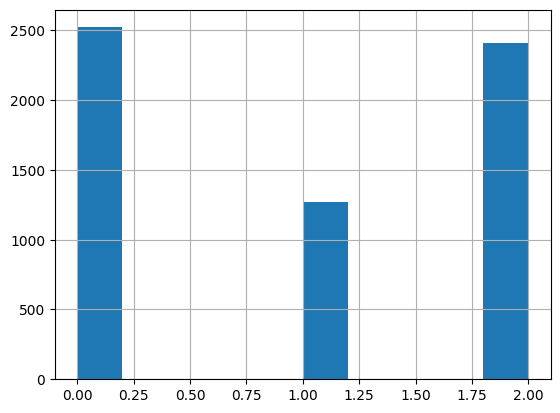

In [9]:
states = pd.Series(model.predict(feat_df), index = df.index[1:])
states.name = "State"
states.hist()

In [10]:
full_df = pd.concat([df.iloc[1:], states], axis=1)
full_df.head()

,Open,High,Low,Close,Adj Close,Volume,returns,range,VIX,State
Date,,,,,,,,,,
2000-01-04,143.53125,144.06250,139.640625,139.75,89.641975,8089800,-0.039891,4.421875,27.010000,1
2000-01-05,139.93750,141.53125,137.250000,140.00,89.802299,12177900,0.001787,4.281250,26.410000,1
2000-01-06,139.62500,141.50000,137.750000,137.75,88.359108,6227200,-0.016202,3.750000,25.730000,1
2000-01-07,140.31250,145.75000,140.062500,145.75,93.490623,8066500,0.056452,5.687500,21.719999,1
2000-01-10,146.25000,146.90625,145.031250,146.25,93.811348,5741700,0.003425,1.875000,21.709999,2


<Axes: xlabel='Date'>

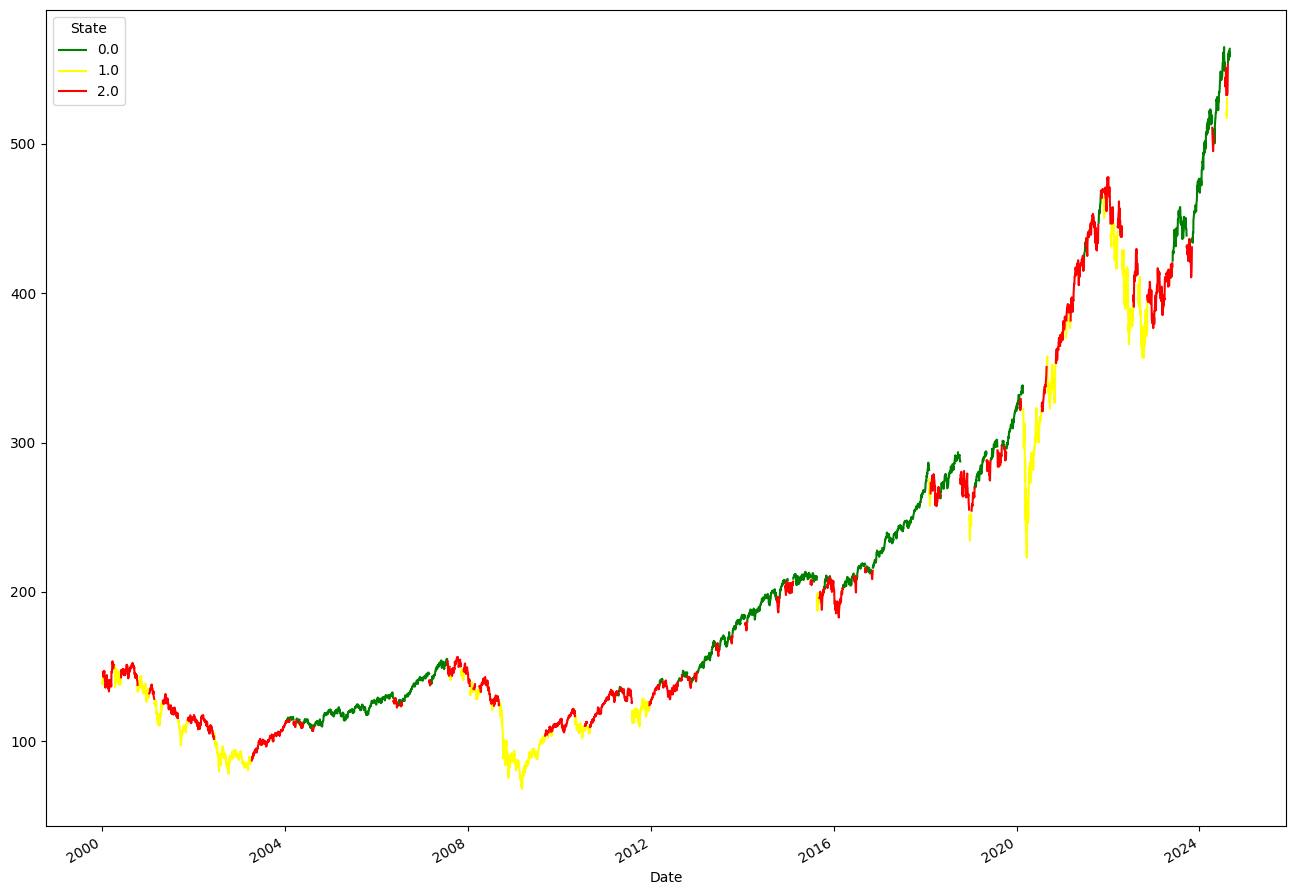

In [11]:
color_map = {
    0.0: "green",
    1.0: "yellow",
    2.0: "red"
}
(
    pd.concat([df.Close, states], axis=1)
    .dropna()
    .set_index("State", append=True)
    .Close
    .unstack("State")
    .plot(color=color_map, figsize=[16, 12])
)

<Axes: xlabel='Date'>

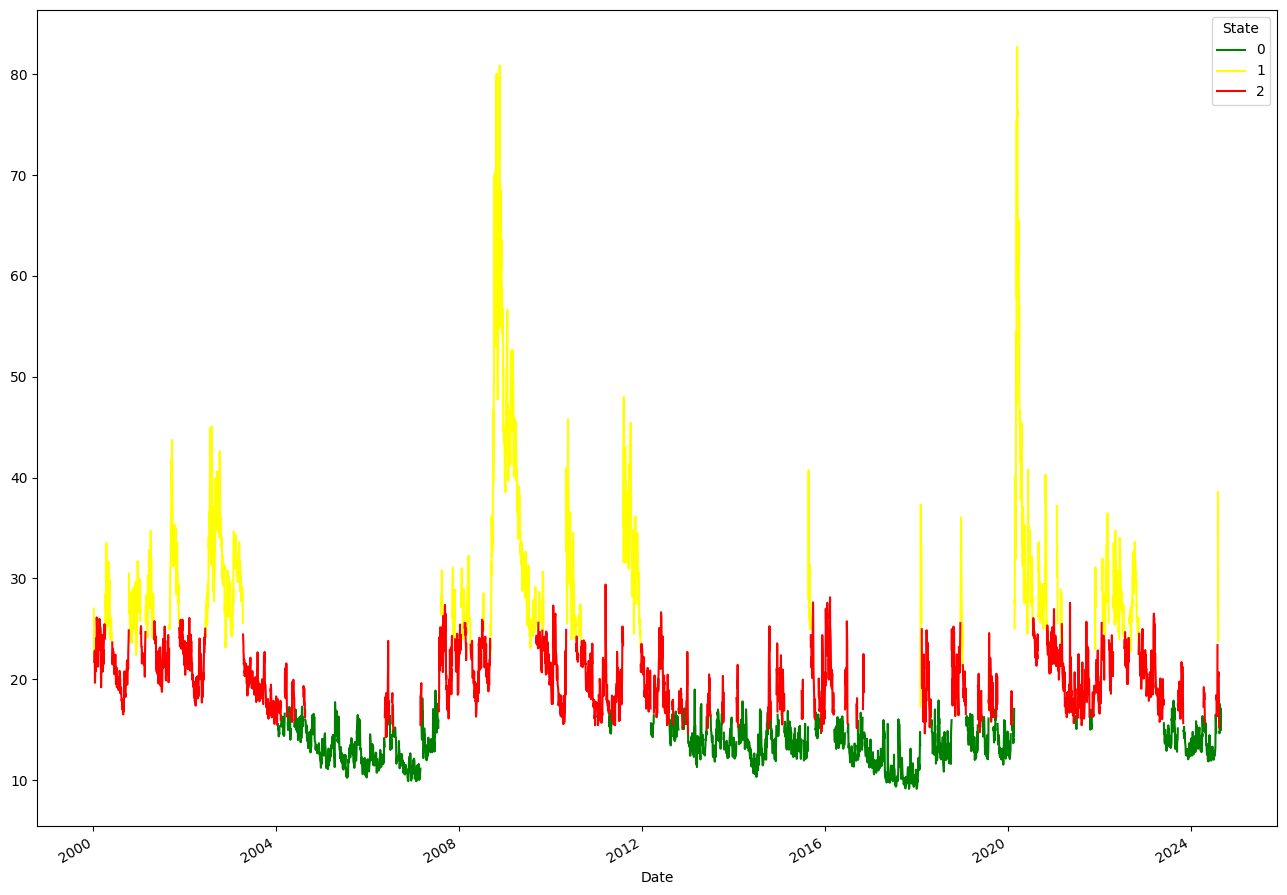

In [12]:
color_map = {
    0.0: "green",
    1.0: "yellow",
    2.0: "red"
}
(
    pd.concat([full_df.VIX, states], axis=1)
    .dropna()
    .set_index("State", append=True)
    .VIX
    .unstack("State")
    .plot(color=color_map, figsize=[16, 12])
)

In [13]:
summary_df = full_df.groupby('State')[['returns', 'VIX']].agg(['mean', 'std'])
summary_df.head()

returns                  VIX          
           mean       std       mean       std
State                                         
0      0.000805  0.005781  13.347930  1.737434
1     -0.000810  0.021806  32.591717  9.383282
2      0.000146  0.010142  20.079092  2.652486

In [14]:
train_df = full_df[full_df.index < '2019-12-31'].dropna()
test_df = full_df[full_df.index >= '2019-12-31']


In [15]:
model = hmm.GaussianHMM( #observations follow Gaussian dist (assumption)
    n_components=3,#number of market states
    covariance_type = "full", #full covariance matrix (emission/transitiion matrices?)
    n_iter=100
)

model.fit(train_df[['returns', 'VIX']])

# win_len = 2707
# i = 2707
# while i < len(full_df):
#     window = full_df.iloc[i-win_len:i][['returns', 'VIX']]
#     model.fit(window)
#     next_day = model.predict(full_df.iloc[[i]][['returns', 'VIX']].values) 
#     print(next_day)
preds = pd.Series(model.predict(test_df[['returns', 'VIX']]), index=test_df.index)
preds.name = 'preds'

In [16]:
preds

Date
2019-12-31    1
2020-01-02    2
2020-01-03    0
2020-01-06    0
2020-01-07    0
             ..
2024-08-26    0
2024-08-27    0
2024-08-28    0
2024-08-29    0
2024-08-30    0
Name: preds, Length: 1175, dtype: int64

<Axes: xlabel='Date'>

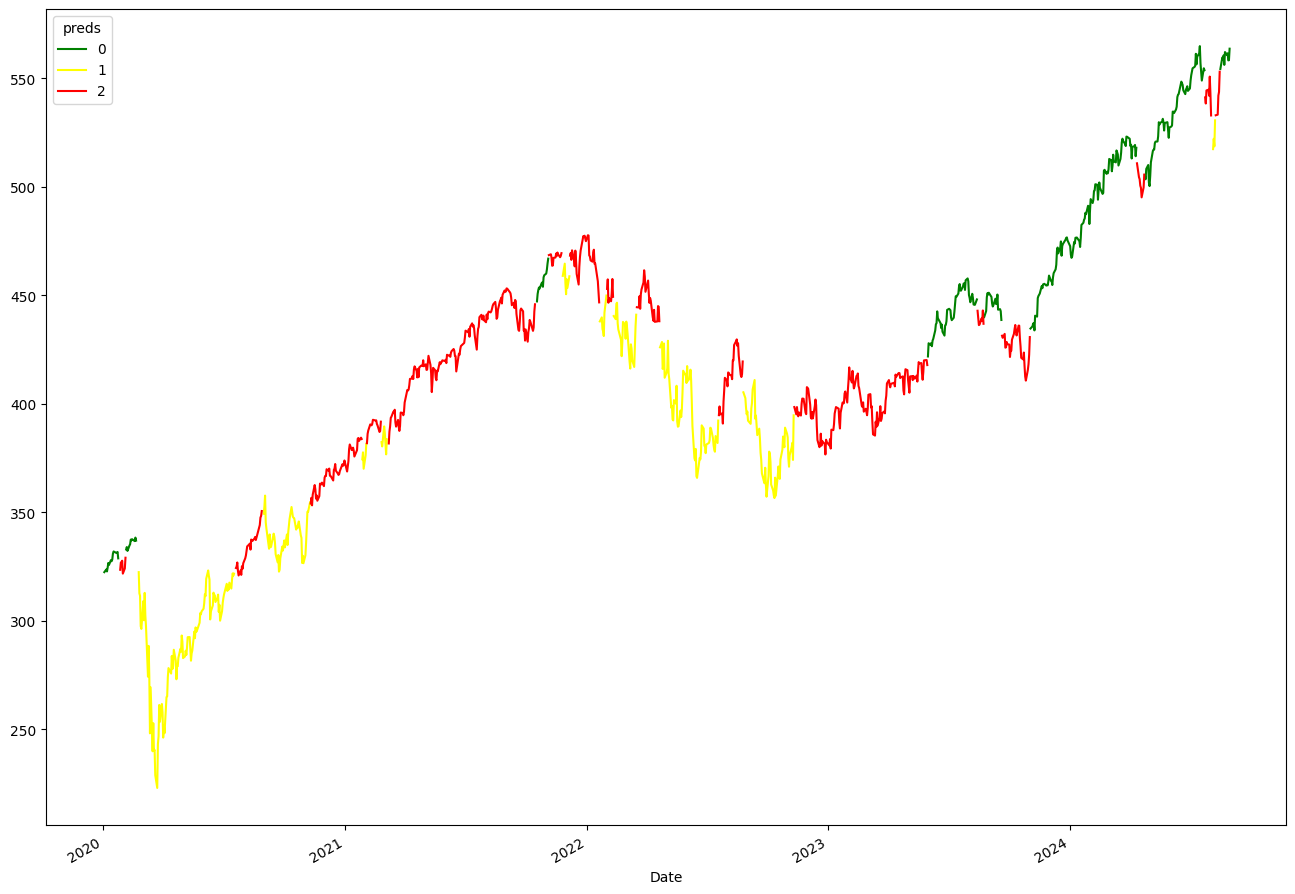

In [17]:
color_map = {
    0.0: "green",
    1.0: "yellow",
    2.0: "red"
}
(
    pd.concat([test_df.Close, preds], axis=1)
    .dropna()
    .set_index("preds", append=True)
    .Close
    .unstack("preds")
    .plot(color=color_map, figsize=[16, 12])
)

<Axes: xlabel='Date'>

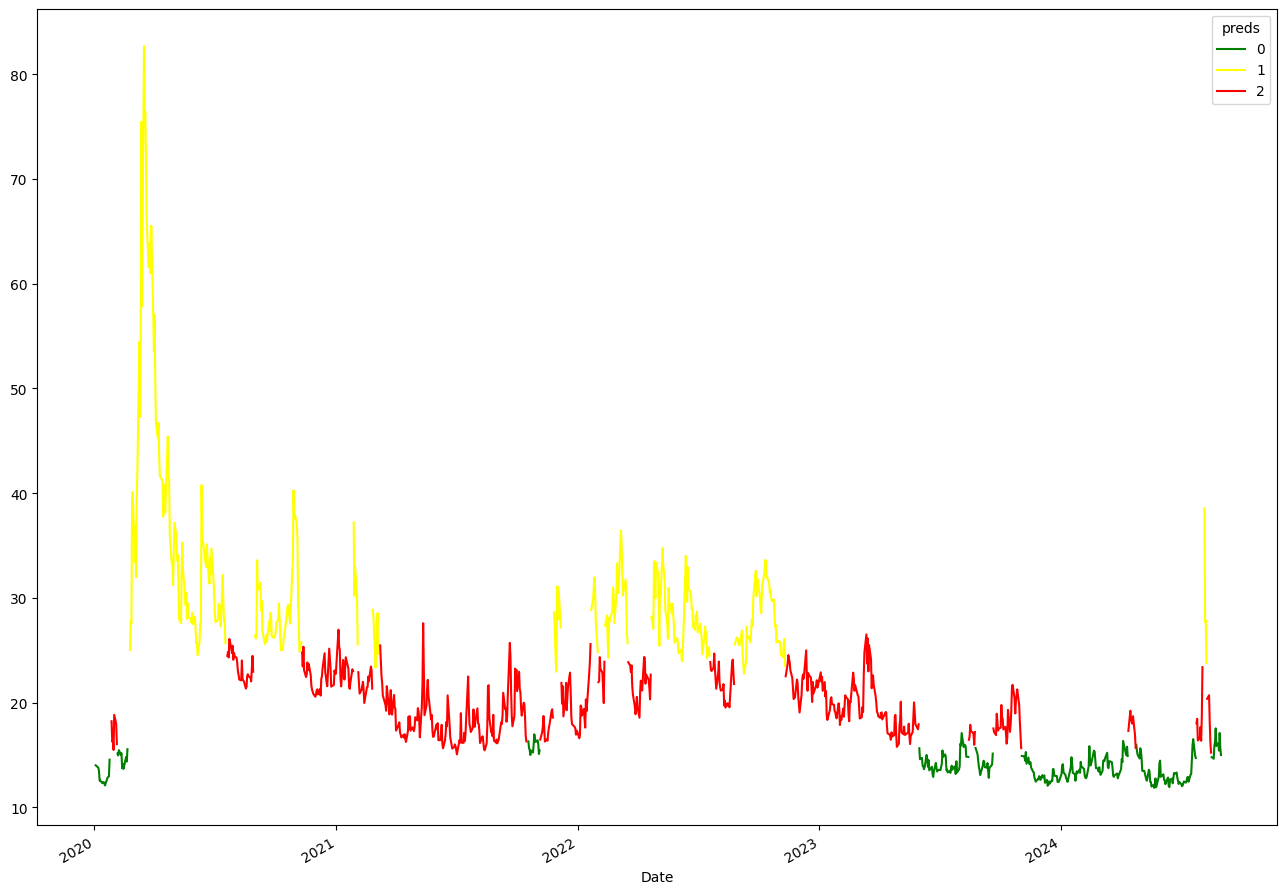

In [18]:
color_map = {
    0.0: "green",
    1.0: "yellow",
    2.0: "red"
}
(
    pd.concat([test_df.VIX, preds], axis=1)
    .dropna()
    .set_index("preds", append=True)
    .VIX
    .unstack("preds")
    .plot(color=color_map, figsize=[16, 12])
)